<a href="https://colab.research.google.com/github/vvijaykar/housing_project/blob/main/Project_Runway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Pip Installs & Dependencies

In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

## Google Drive

In [ ]:
# Will Authorize and Mount your GoogleDrive to access files
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Access Files using PyDrive
# https://pythonhosted.org/PyDrive/

def GoogDrive():
  !pip install -U -q PyDrive
  
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

In [ ]:

def driveCSVtoDF(csv_filename,shareable_link):
    # Using PyDrive Object, acess files and store in a dataframe.
    
    # isolate the doc id
    fileID = shareable_link.split('=')[1]

    # Get the Drive Object
    drive = GoogDrive()

    #create the file from id and filename
    downloaded = drive.CreateFile({'id':fileID}) 
    downloaded.GetContentFile(csv_filename)

    #create a dataframe
    df = pd.read_csv(csv_filename)

    return drive, df




In [ ]:
# File Info from your Drive:
# ** Make sure your file is NOT A GOOGLE DOCUMENT .gsheet or being automatically convertect on upload.  
csv_filename = 'train.csv'
shareable_link = 'https://drive.google.com/open?id=1-3VY-vFNglOXDV0ur46AuA7hO4rKBiON'

drive, df = driveCSVtoDF(csv_filename,shareable_link)
all_columns = df.columns
df.head()

# Initial Look at the Data

In [ ]:
# plot the dataset, referencing dataframe column names

my_x = 'SalePrice'
my_y = 'Neighborhood'

alt.Chart(df).mark_bar().encode(
  x= my_x,
  y=alt.Y(my_y, sort='-x'),
  color=my_y,   
)

In [ ]:
# quicklook at how many NA values we have in each column filtering out the zeros
df.isna().sum()[df.isna().sum() > 0]

## Correlation Analysis

In [ ]:
# Some Initial Correlation on the Data to target the Regression
target = ['SalePrice']

# Get the data in a presentable format
corr_data = pd.DataFrame(df.corr(method='pearson',min_periods=1)[target])\
.sort_values(by=target,ascending=False).reset_index()

# isolate the Top 10 & Bottm 10 into lists
top10_corr = corr_data['index'][0:11].to_list()
high_corr = corr_data[corr_data['SalePrice'].abs() > 0.2]['index'].to_list()

super_high_corr = corr_data[corr_data['SalePrice'].abs() > 0.7]['index'].to_list()
low_corr = corr_data[corr_data['SalePrice'].abs() < 0.2]['index'].to_list()

# Display data.  Use .T to save screen space or remove to see the whole set
corr_data.head(10).T

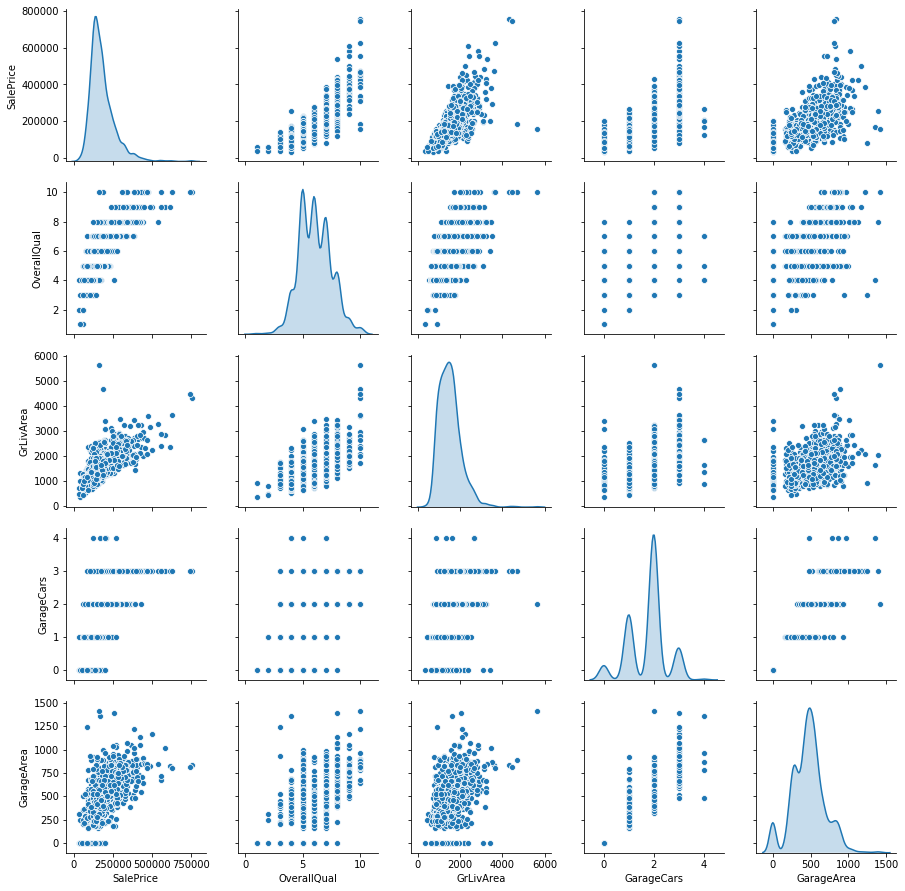

In [ ]:
# View a pair plot grid of the top 5 most correlated data to see what's going on
sns.pairplot(df[top10_corr[:5]], diag_kind="kde")

In [ ]:
# Since correlation only looks at numerical data, we want to know which fields were excluded
# and determine which categories we want to keep

# capture all the fields not captured by correlation
categorical  = [item for item in df.columns if item not in corr_data['index'].to_list()]

# print each category to see their unique values
for col in categorical:
  print(f'{categorical.index(col)}. {col} >> {df[col].unique()}')


0. MSZoning >> ['RL' 'RM' 'C (all)' 'FV' 'RH']
1. Street >> ['Pave' 'Grvl']
2. Alley >> [nan 'Grvl' 'Pave']
3. LotShape >> ['Reg' 'IR1' 'IR2' 'IR3']
4. LandContour >> ['Lvl' 'Bnk' 'Low' 'HLS']
5. Utilities >> ['AllPub' 'NoSeWa']
6. LotConfig >> ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
7. LandSlope >> ['Gtl' 'Mod' 'Sev']
8. Neighborhood >> ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
9. Condition1 >> ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
10. Condition2 >> ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
11. BldgType >> ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
12. HouseStyle >> ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
13. RoofStyle >> ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
14. RoofMatl >> ['CompShg' 'WdS

In [ ]:
# using the output above, we can list the #'s for the corresponding items
# we want to capture in a separate list

# which categories should we keep?  Toss those in a list for us to use later.
keep_5 = [0,8,11,33,42]
keep_10 = [0,3,8,11,12,15,28,33,41,42]
keep_15 = [0,3,6,8,11,12,13,15,20,26,28,31,33,41,42]

# convert the index numbers to categories
keepers5 = [cat for cat in categorical if categorical.index(cat) in keep_5]
keepers10 = [cat for cat in categorical if categorical.index(cat) in keep_10]
keepers15 = [cat for cat in categorical if categorical.index(cat) in keep_15]

# Preview Results
print(keepers5)
print(keepers10)
print(keepers15)




['MSZoning', 'Neighborhood', 'BldgType', 'GarageType', 'SaleCondition']
['MSZoning', 'LotShape', 'Neighborhood', 'BldgType', 'HouseStyle', 'Exterior1st', 'CentralAir', 'GarageType', 'SaleType', 'SaleCondition']
['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Foundation', 'Heating', 'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition']


#Cleaning the Data

In [ ]:
# Define a switcher function to tranform ordinal scales to numeric scales

def NumScale(descriptive_scale):
  switcher = {
      # KitchenQual
      'Ex':5,
      'Gd':4,
      'TA':3,
      'Fa':2,
      'Po':1,
      'NA':0,

      # BsmtExposure
      'Gd':4,
      'Av':3,	
      'Mn':2,
      'No':1,

      # BsmtFinType1
      'GLQ':6,
      'ALQ':5,
      'BLQ':4,
      'Rec':3,
      'LwQ':2,
      'Unf':1,

      # LandSlope
      'Gtl':3,
      'Mod':2,	
      'Sev':1,

      # GarageFinish
       'Fin':3,	
       'RFn':2,	
       'Unf':1,
      
      # Just in case we run it again
       6:6,
       5:5,
       4:4,
       3:3,
       2:2,
       1:1,
       'nan':0,
       
  }
  return switcher.get(descriptive_scale,0)


In [ ]:
# Which fields need to be transformed from Oridinal data to numerical?
# What are their currrent values?
Scale_List = ['BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'BsmtQual',
'ExterCond',
'ExterQual',
'GarageCond',
'GarageFinish',
'GarageQual',
'LandSlope',
'PoolQC',
'KitchenQual',
'FireplaceQu',
'HeatingQC',
]

for col in Scale_List:
  print(df[col].unique())

['TA' 'Gd' nan 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' 'Fa' 'Po' 'Ex']
['Gd' 'TA' 'Ex' 'Fa']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['Gtl' 'Mod' 'Sev']
[nan 'Ex' 'Fa' 'Gd']
['Gd' 'TA' 'Ex' 'Fa']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Ex' 'Gd' 'TA' 'Fa' 'Po']


##Begin Transforming Data 

In [ ]:
# Replace Ordinal with Number Scales
housing = df.copy(deep=True)
for i, row in housing.iterrows():
  for col in Scale_List:
    value = row[col]
    new_value = NumScale(row[col])
    housing.loc[i,col] = new_value

# Confirming Ordinal Replacement
for col in Scale_List:
  print(f'{col} >> {housing[col].unique()}')

BsmtCond >> [3 4 0 2 1]
BsmtExposure >> [1 4 2 3 0]
BsmtFinType1 >> [6 5 1 3 4 0 2]
BsmtFinType2 >> [1 4 0 5 3 2 6]
BsmtQual >> [4 3 5 0 2]
ExterCond >> [3 4 2 1 5]
ExterQual >> [4 3 5 2]
GarageCond >> [3 2 0 4 1 5]
GarageFinish >> [2 1 3 0]
GarageQual >> [3 2 4 0 5 1]
LandSlope >> [3 2 1]
PoolQC >> [0 5 2 4]
KitchenQual >> [4 3 5 2]
FireplaceQu >> [0 3 4 2 5 1]
HeatingQC >> [5 4 3 2 1]


In [ ]:
# Find correlation of ordinal data
corr_data = pd.DataFrame(housing.corr(method='pearson',min_periods=1)[target])\
.sort_values(by=target,ascending=False).reset_index()

corr_data.head(20)

,index,SalePrice
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,ExterQual,0.682639
4,KitchenQual,0.659600
5,GarageCars,0.640409
6,GarageArea,0.623431
7,TotalBsmtSF,0.613581
8,1stFlrSF,0.605852
9,BsmtQual,0.585207


In [ ]:
# Cast some numeric codes to string and other discrete edits
# housing1.MSSubClass = housing1.MSSubClass.astype(str)

fillzero = ['MasVnrArea', 'GarageYrBlt', 'LotFrontage']
housing[fillzero].fillna(0)

housing.MSSubClass = housing.MSSubClass.astype(str)




In [ ]:
numeric_cols = high_corr
categorical_cols= keepers10
ordinal_cols = Scale_List

# Assembling the columns to be used to train the model
housing_cols = numeric_cols + categorical_cols + ordinal_cols
print(housing_cols)
exclude_cols = [col for col in all_columns if col not in housing_cols]

['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'MSZoning', 'LotShape', 'Neighborhood', 'BldgType', 'HouseStyle', 'Exterior1st', 'CentralAir', 'GarageType', 'SaleType', 'SaleCondition', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'ExterCond', 'ExterQual', 'GarageCond', 'GarageFinish', 'GarageQual', 'LandSlope', 'PoolQC', 'KitchenQual', 'FireplaceQu', 'HeatingQC']


In [ ]:
# confirming all columns accounted for

ac = len(all_columns)
hc = len(housing_cols)
ec = len(exclude_cols)
print(f'AC = {ac}, HC = {hc}, EC = {ec}: {ac-hc}')

AC = 81, HC = 48, EC = 33: 33


In [ ]:
# Getting Test Case versions of the clean data

# 1) All Original Data (Not Cleaned)
data1_raw = df.copy(deep=True)


# 2) All Data Cleaned
data2_cleaned = housing.copy(deep=True)


# ------ The following uses Cleaned Data Only ---------

# 3) Data using Top 10 positive correlations only
data3_topCorr = housing[top10_corr].copy(deep=True)


# 4) Data using all correlations above an absolute value of 0.2
data4_highCorr = housing[high_corr].copy(deep=True)


# 5) Data using Scaled from High Correlations with 5 selected categorical
data5_highkeep5 = housing[high_corr + keepers5].copy(deep=True)


# 6) Data using Scaled from High Correlations with 10 selected categorical
data6_highkeep10 = housing[high_corr + keepers10].copy(deep=True)


# 7) Data using Scaled from High Correlations with 15 selected categorical
data7_highkeep15 = housing[high_corr + keepers15].copy(deep=True)


# 8) Data using Scaled from High Correlations with 15 selected categorical
data8_highkeepscaled = housing[high_corr + keepers10 + Scale_List].copy(deep=True)



#SciKitLear Regression Model

In [ ]:
def skReg(df2,target='SalePrice',title='SK Regression Model'):
  
  print(f'Orginal Shape of DF = {df2.shape}')

  # prepare dataframe with dummy encoded data
  df = pd.get_dummies(df2).fillna(0).copy(deep=True)
  print(f'New Shape of DF = {df.shape}')
  
  y = df[target].values.reshape(-1, 1)
  X = df.drop(target, axis=1)
  print(X.shape, y.shape)

  # Split the data into training and testing
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  # Create a StandardScater model and fit it to the training data
  from sklearn.preprocessing import StandardScaler
  X_scaler = StandardScaler().fit(X_train)
  y_scaler = StandardScaler().fit(y_train)

  # Transform the training and testing data using the X_scaler and y_scaler models
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)
  y_train_scaled = y_scaler.transform(y_train)
  y_test_scaled = y_scaler.transform(y_test)

  # Create a LinearRegression model and fit it to the scaled training data
  from sklearn.linear_model import LinearRegression
  regression = LinearRegression()
  regression.fit(X_train_scaled, y_train_scaled)

  # Plot y_test_scaled vs y_test_scaled
  # Scatter plot y_test_scaled vs predictions

  import matplotlib.pyplot as plt
  predictions = regression.predict(X_test_scaled)
  regression.fit(X_train_scaled, y_train_scaled)
  plt.scatter(regression.predict(X_train_scaled), regression.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
  plt.scatter(regression.predict(X_test_scaled), regression.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
  plt.legend()
  plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
  plt.title(title)
  plt.show()  

  from sklearn.metrics import mean_squared_error

  MSE = mean_squared_error(y_test_scaled, predictions)
  r2 = regression.score(X_test_scaled, y_test_scaled)


  return   regression, predictions






In [ ]:
def prepData(df_raw,target):

  print(f'''
  This function will return 9 objects:
    1) dummy encoded df
    
    Split Data
    2) X_train
    3) X_test
    4) y_train
    5) y_test

    Split Scaled Data
    6) X_train_scaled
    7) X_test_scaled
    8) y_train_scaled
    9) y_test_scaled
 
    ''')
  
  print(f'Orginal Shape of DF = {df_raw.shape}')

  # prepare dataframe with dummy encoded data
  df = pd.get_dummies(df_raw).fillna(0).copy(deep=True)
  print(f'New Shape of DF = {df.shape}')
  
  y = df[target].values.reshape(-1, 1)
  X = df.drop(target, axis=1)
  print(X.shape, y.shape)

  # Split the data into training and testing
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  # Create a StandardScater model and fit it to the training data
  from sklearn.preprocessing import StandardScaler
  X_scaler = StandardScaler().fit(X_train)
  y_scaler = StandardScaler().fit(y_train)

  # Transform the training and testing data using the X_scaler and y_scaler models
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)
  y_train_scaled = y_scaler.transform(y_train)
  y_test_scaled = y_scaler.transform(y_test)

  return df, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

## Run each data set through the model to view scatter plot and score

Orginal Shape of DF = (1460, 81)
New Shape of DF = (1460, 290)
(1460, 289) (1460, 1)


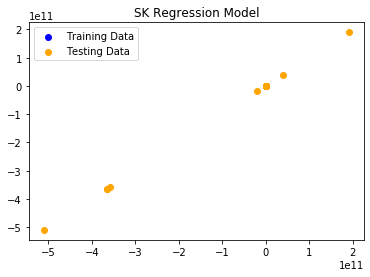

Orginal Shape of DF = (1460, 81)
New Shape of DF = (1460, 253)
(1460, 252) (1460, 1)


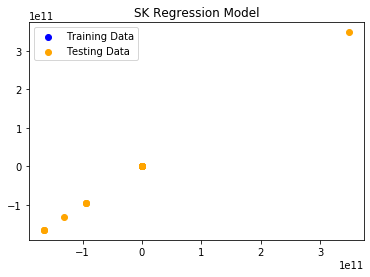

Orginal Shape of DF = (1460, 11)
New Shape of DF = (1460, 11)
(1460, 10) (1460, 1)


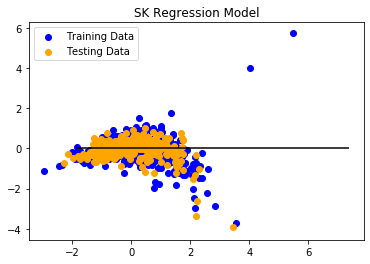

Orginal Shape of DF = (1460, 23)
New Shape of DF = (1460, 23)
(1460, 22) (1460, 1)


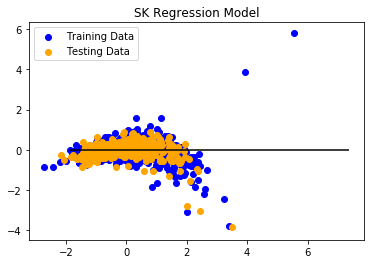

Orginal Shape of DF = (1460, 28)
New Shape of DF = (1460, 70)
(1460, 69) (1460, 1)


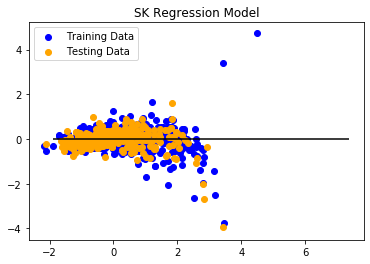

Orginal Shape of DF = (1460, 33)
New Shape of DF = (1460, 108)
(1460, 107) (1460, 1)


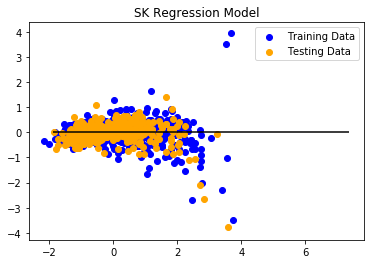

Orginal Shape of DF = (1460, 38)
New Shape of DF = (1460, 138)
(1460, 137) (1460, 1)


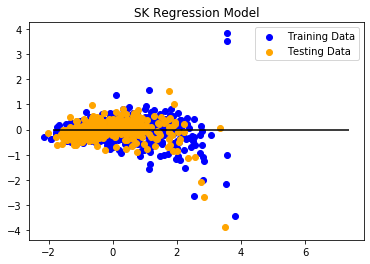

Orginal Shape of DF = (1460, 48)
New Shape of DF = (1460, 123)
(1460, 122) (1460, 1)


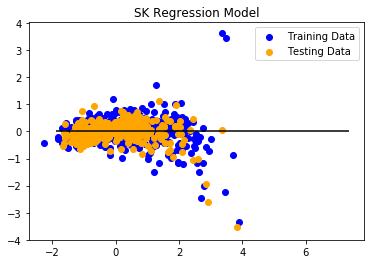

In [ ]:
# Run each data set through the model to view scatter plot and score
data_sets = [data1_raw,data2_cleaned,data3_topCorr,data4_highCorr,data5_highkeep5,data6_highkeep10,data7_highkeep15,data8_highkeepscaled]
for set in data_sets:
  skReg(set)

Orginal Shape of DF = (1460, 48)
New Shape of DF = (1460, 123)
(1460, 122) (1460, 1)


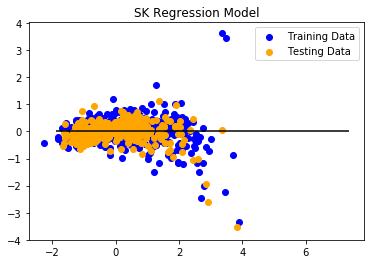

In [ ]:
# Capturing both the Regression Model and Predictions into their own variables
regression, predictions = skReg(data8_highkeepscaled)

# Preparing the Data Set for Tesor Flow

In [ ]:
# selecting my official dataset
my_data = data8_highkeepscaled.copy(deep=True)

# encoding categorical data and filling any stragglers with 0
my_data_encoded = pd.get_dummies(my_data).fillna(0)

# isolate the target from the data 
target = 'SalePrice'
y = my_data_encoded[target].values.reshape(-1, 1)
X = my_data_encoded.drop(target, axis=1)
print(X.shape, y.shape)

# Splitting data into Train & Test
train_dataset = my_data_encoded.sample(frac=0.8,random_state=0)
test_dataset = my_data_encoded.drop(train_dataset.index)


(1460, 122) (1460, 1)


In [ ]:
my_data_encoded, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepData(my_data,target='SalePrice')


  This function will return 9 objects:
    1) dummy encoded df
    
    Split Data
    2) X_train
    3) X_test
    4) y_train
    5) y_test

    Split Scaled Data
    6) X_train_scaled
    7) X_test_scaled
    8) y_train_scaled
    9) y_test_scaled
 
    
Orginal Shape of DF = (1460, 48)
New Shape of DF = (1460, 123)
(1460, 122) (1460, 1)


In [ ]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = regression.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.1540742492020195, R2: 0.8664650848255326


In [ ]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.15413380277209562, R2: 0.8664134702243281


In [ ]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.15305693475387475, R2: 0.8673467830927145


In [ ]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.15265710227903004, R2: 0.8676933146895837


In [ ]:
# target = 'SalePrice'
train_stats = X_train.describe()
# train_stats.pop(target)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
OverallQual,1095.0,6.129680,1.366746,1.0,5.0,6.0,7.0,10.0
GrLivArea,1095.0,1531.213699,527.197908,334.0,1148.0,1478.0,1795.0,5642.0
GarageCars,1095.0,1.784475,0.733836,0.0,1.0,2.0,2.0,4.0
GarageArea,1095.0,477.539726,210.563755,0.0,349.5,484.0,576.0,1418.0
TotalBsmtSF,1095.0,1060.763470,443.879480,0.0,795.5,996.0,1299.5,6110.0
...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,1095.0,0.003653,0.060357,0.0,0.0,0.0,0.0,1.0
SaleCondition_Alloca,1095.0,0.004566,0.067450,0.0,0.0,0.0,0.0,1.0
SaleCondition_Family,1095.0,0.015525,0.123685,0.0,0.0,0.0,0.0,1.0
SaleCondition_Normal,1095.0,0.829224,0.376485,0.0,1.0,1.0,1.0,1.0


In [ ]:
train_labels = train_dataset.pop(target)
test_labels = test_dataset.pop(target)

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [ ]:
normed_train_data

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,ExterCond,ExterQual,GarageCond,GarageFinish,GarageQual,LandSlope,PoolQC,KitchenQual,FireplaceQu,HeatingQC,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1023,0.636782,-0.051620,0.293696,-0.192529,0.642599,0.861699,0.772519,0.268055,1.107383,1.019908,0.295282,-0.519066,0.591028,-0.943829,-0.409502,0.458644,-0.804912,-0.428642,-0.766285,-0.683637,-0.813623,1.711091,1.927758,-0.587611,1.158844,-0.275341,0.577842,-0.22174,1.057006,0.253157,1.429095,0.248361,0.227137,-0.070221,0.743017,1.192774,0.890326,-0.060523,-0.211675,-0.11375,...,-0.146409,-0.218639,-0.121717,-0.03022,-0.042757,-0.18952,-0.03022,-0.199624,-0.424020,-0.03022,-0.413481,-0.271039,-0.03022,-0.132823,1.333253,-0.411967,-0.132823,-0.276814,0.276814,-0.074193,0.825472,-0.117797,-0.25921,-0.080174,-0.598526,-0.167760,-0.060523,-0.042757,-0.080174,-0.05239,-0.060523,-0.297302,-0.03022,0.382705,-0.263197,-0.060523,-0.067698,-0.125521,0.453607,-0.299116
810,-0.094883,-0.421500,0.293696,0.030681,-0.046777,0.357732,-1.062423,-0.962636,0.094500,0.682273,0.225467,-0.023278,0.591028,0.469147,0.576436,1.294557,-0.804912,-0.717934,1.245902,-0.054858,1.118952,-1.278576,0.114274,-0.587611,0.682160,0.849652,-0.562225,-0.22174,-0.683478,0.253157,0.305722,0.248361,0.227137,6.919929,0.743017,0.088260,-2.221080,-0.060523,-0.211675,-0.11375,...,-0.146409,-0.218639,-0.121717,-0.03022,-0.042757,-0.18952,-0.03022,-0.199624,2.356228,-0.03022,-0.413481,-0.271039,-0.03022,-0.132823,-0.749360,-0.411967,-0.132823,-0.276814,0.276814,-0.074193,0.825472,-0.117797,-0.25921,-0.080174,-0.598526,-0.167760,-0.060523,-0.042757,-0.080174,-0.05239,-0.060523,-0.297302,-0.03022,0.382705,-0.263197,-0.060523,-0.067698,-0.125521,0.453607,-0.299116
1384,-0.094883,-0.518237,-1.069005,-0.938147,-1.128152,-1.221364,-1.062423,-0.347291,-1.049078,-1.681169,0.146643,-0.600725,-0.960953,-0.533258,0.069382,-0.737709,0.465642,-0.717934,-0.766285,-0.152455,-0.813623,-0.478334,0.114274,0.357226,-0.271210,-0.275341,-0.562225,-0.22174,-0.683478,0.253157,-0.817652,0.248361,0.227137,-0.070221,-0.760871,-1.016253,-1.183945,-0.060523,-0.211675,-0.11375,...,-0.146409,-0.218639,-0.121717,-0.03022,-0.042757,-0.18952,-0.03022,-0.199624,-0.424020,-0.03022,-0.413481,-0.271039,-0.03022,-0.132823,-0.749360,-0.411967,7.521959,-0.276814,0.276814,-0.074193,-1.210321,-0.117797,-0.25921,-0.080174,1.669245,-0.167760,-0.060523,-0.042757,-0.080174,-0.05239,-0.060523,-0.297302,-0.03022,0.382705,-0.263197,-0.060523,-0.067698,-0.125521,0.453607,-0.299116
626,-0.826548,-0.207159,-1.069005,-0.909652,-0.186455,0.649774,-1.062423,-0.347291,-0.362931,-0.330631,0.193937,-0.600725,0.591028,-0.978772,-1.620796,-0.737709,-0.804912,-0.717934,-0.766285,0.144133,-0.813623,0.919841,0.114274,-0.587611,-1.224579,-0.275341,-0.562225,-0.22174,-0.683478,0.253157,0.305722,0.248361,0.227137,-0.070221,-0.760871,0.640517,-1.183945,-0.060523,-0.211675,-0.11375,...,-0.146409,-0.218639,-0.121717,-0.03022,-0.042757,-0.18952,-0.03022,-0.199624,-0.424020,-0.03022,-0.413481,-0.27

#Beginning Tensor Flow

## Getting TF Dependencies

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7872      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.7965801 ],
       [ 0.03109068],
       [-0.2235573 ],
       [ 0.7931919 ],
       [ 0.98013735],
       [ 0.25236034],
       [-0.5637282 ],
       [ 0.79318076],
       [-0.88113075],
       [-0.08099233]], dtype=float32)

In [ ]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:39327583227.3242,  mean_absolute_error:181727.0156,  mean_squared_error:39327584256.0000,  val_loss:38134234350.4658,  val_mean_absolute_error:181630.4531,  val_mean_squared_error:38134235136.0000,  
....................................................................................................
Epoch: 100, loss:6291003347.5799,  mean_absolute_error:63120.5391,  mean_squared_error:6291002880.0000,  val_loss:7698516135.1598,  val_mean_absolute_error:70753.9062,  val_mean_squared_error:7698516480.0000,  
....................................................................................................
Epoch: 200, loss:1631774551.6712,  mean_absolute_error:25184.6172,  mean_squared_error:1631774592.0000,  val_loss:2751042302.8311,  val_mean_absolute_error:30970.8262,  val_mean_squared_error:2751042304.0000,  
....................................................................................................
Epoch: 300, loss:1245110667.1050,  mean_absolute_error:2136

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,5.484255e+08,13601.512695,548425536.0,1.799931e+09,23073.757812,1.799931e+09,995
996,5.477960e+08,13469.416992,547796096.0,1.799575e+09,23088.703125,1.799575e+09,996
997,5.480112e+08,13550.189453,548011136.0,1.798639e+09,23076.812500,1.798639e+09,997
998,5.474755e+08,13512.952148,547475520.0,1.797955e+09,23074.449219,1.797956e+09,998
999,5.485582e+08,13525.086914,548558144.0,1.797259e+09,23065.451172,1.797259e+09,999


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [SalePrice]')

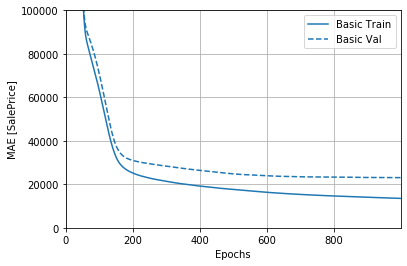

In [ ]:
plotter.plot({'Basic': history}, metric = 'mean_absolute_error')
plt.ylim([0, 100000])
plt.ylabel('MAE [SalePrice]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:39327116975.3425,  mean_absolute_error:181725.7656,  mean_squared_error:39327117312.0000,  val_loss:38133298797.8813,  val_mean_absolute_error:181628.2188,  val_mean_squared_error:38133297152.0000,  
....................................................................................................
Epoch: 100, loss:3614355404.5662,  mean_absolute_error:43964.6484,  mean_squared_error:3614355200.0000,  val_loss:4778440075.1050,  val_mean_absolute_error:50928.3789,  val_mean_squared_error:4778439680.0000,  
....................................................................................................
Epoch: 200, loss:1394852095.7808,  mean_absolute_error:23252.2383,  mean_squared_error:1394852224.0000,  val_loss:2540578073.7169,  val_mean_absolute_error:29807.7266,  val_mean_squared_error:2540578048.0000,  
....................................................................................................
Epoch: 300, loss:1034744512.9498,  mean_absolute_error:1950

Text(0, 0.5, 'MSE [SalePrice]')

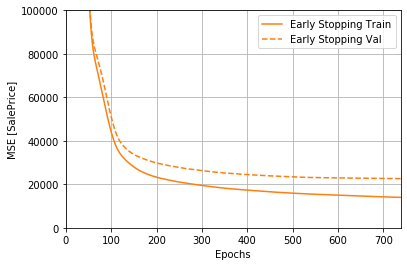

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mean_absolute_error")
plt.ylim([0, 100000])
plt.ylabel('MSE [SalePrice]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Sale Price".format(mae))

365/365 - 0s - loss: 1914238803.7260 - mean_absolute_error: 23011.8848 - mean_squared_error: 1914238720.0000
Testing set Mean Abs Error: 23011.88 Sale Price


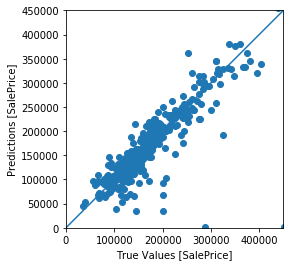

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
lims = [0, 450000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
values = pd.DataFrame(test_predictions).sort_values(by=0)
values.head()

,0
53,660.626526
48,2319.928223
307,34908.855469
144,35012.082031
229,39236.542969


In [ ]:
X_test.iloc[53]

OverallQual                 8.0
GrLivArea                2898.0
GarageCars                  2.0
GarageArea                665.0
TotalBsmtSF              1565.0
                          ...  
SaleCondition_AdjLand       0.0
SaleCondition_Alloca        0.0
SaleCondition_Family        0.0
SaleCondition_Normal        0.0
SaleCondition_Partial       0.0
Name: 1024, Length: 122, dtype: float64

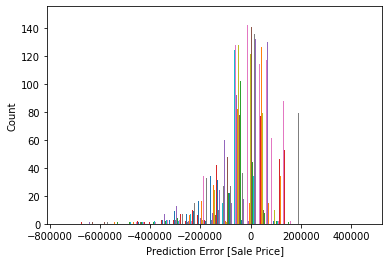

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Sale Price]")
_ = plt.ylabel("Count")